In [4]:
import re
import csv
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
#import nltk
from collections import Counter 
import matplotlib.pyplot as plt

# On génère les série temporelle

In [151]:
def generate_first_type_time_series(nb_series, size):
    return np.array([[np.sin(np.divide(2*np.pi*i*t, 64)) for t in range(size)] for i in range(1,nb_series+1)])

In [152]:
def generate_second_type_time_series(nb_series, size):
    fst_type = generate_first_type_time_series(nb_series, size)
    result = []
    frac = 1/(nb_series-1)
    for i in range(1,nb_series+1):
        loc = []
        for t in range(1,size+1):
            fst = fst_type[i-1,t-1]
            snd=frac*np.sum(np.delete(fst_type[:,t-1], i-1, axis=0))
            loc.append(fst+snd)
        result.append(loc)
    return np.array(result)

In [153]:
fst_series = generate_first_type_time_series(6,64)
snd_series = generate_second_type_time_series(6,64)

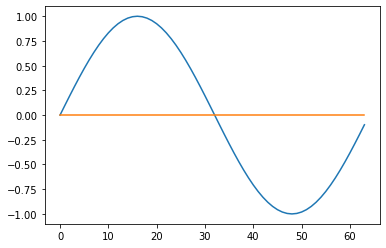

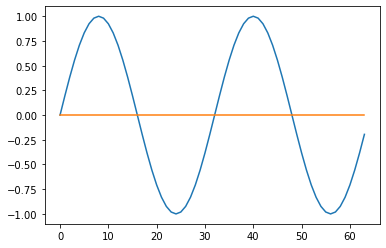

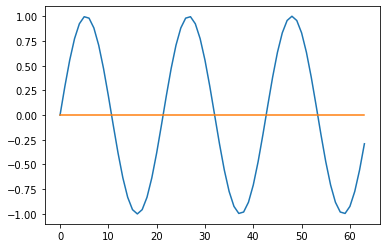

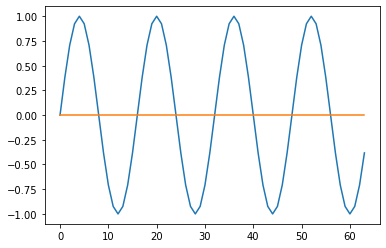

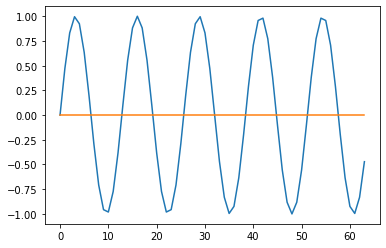

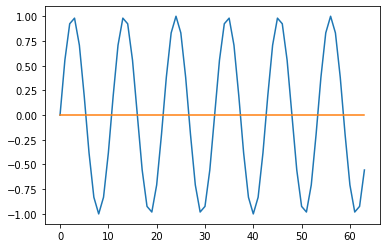

In [154]:
for serie in fst_series:
    plt.plot(serie)
    plt.plot([0 for i in range(64)])
    plt.show()

In [230]:
class GRU_forecaster(nn.Module):
    def __init__(self, nb_cells, hidden_size, input_size, rnn_dropout, bidirectional=False):
        super(GRU_forecaster, self).__init__()
        
        self.nb_cells = nb_cells
        self.hidden_size = hidden_size
        self.input_size = input_size
        
        self.gru = nn.GRU(input_size, hidden_size, nb_cells, batch_first = True, dropout=rnn_dropout,bidirectional=bidirectional)

        if bidirectional:    
            self.fc = nn.Linear(2*hidden_size, 1)
        else:
            self.fc = nn.Linear(hidden_size, 1)
            
        self.convList = nn.ModuleList([nn.Conv1d(1,1,4) for i in range(input_size-1)])
        
        
        self.is_bidirectional = bidirectional 
        #self.dropout = nn.Dropout(0.2)
        nn.init.xavier_uniform_(self.fc.weight.data)  # Xavier/Glorot init for tanh
        nn.init.zeros_(self.fc.bias.data)  # Xavier/Glorot init for tanh
        
            
    
    def forward(self, inputs, hidden):
        batch_size = inputs.size(0)
        print(self.convList)
        rnn_out, hidden = self.gru(inputs, hidden)
        last_h = hidden[0,-1]
        mat = th.Tensor()
        padding, dilation, kernel_size, stride = self.convList[0].padding[0], self.convList[0].dilation[0], self.convList[0].kernel_size[0], self.convList[0].stride[0]
        l_out = int((self.input_size+2*padding - dilation*(kernel_size-1)-1)/stride+1) #output size pour les filtres cnn
        
        for conv, h in zip(self.convList, hidden[0,:-1,]): 
            x = conv(h).view(l_out,-1)
            mat=th.cat([mat,x],1)
            
        

        print(mat.shape)
        return rnn_out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        #hidden = th.Tensor(self.nb_cells, batch_size, self.hidden_size)
        if self.is_bidirectional:
            hidden = weight.new(2*self.nb_cells, batch_size, self.hidden_size).zero_()
        else:
            hidden = weight.new(self.nb_cells, batch_size, self.hidden_size).zero_()
        return hidden

In [231]:
nb_cells=1
hidden_size=20
input_size=1
gru=GRU_forecaster(nb_cells,hidden_size, input_size, 0.2)

In [232]:
x = th.from_numpy(fst_series[0]).view(1,-1,1).float()
h0=th
print(x.shape)
gru(x,None)

torch.Size([1, 64, 1])
ModuleList()


IndexError: index 0 is out of range

In [164]:
convList = nn.ModuleList([nn.Conv1d(1,1,4) for i in range(19)])
gru = nn.GRU(1,20,1)
x = th.rand(1,64,1)
y_t,_=gru(x)

In [165]:
tensor = th.rand(1,19,64)
print(y_t.shape)

torch.Size([1, 64, 20])


In [192]:
s = []
i=0
z = th.Tensor()
for conv, t in zip(convList, y_t[0,:-1,]):
    print(i)
    i+=1
    t = t.view(1,1,-1)
    x=conv(t).view(17,-1)
    print(x.shape)
    z=th.cat([z,x],1)

0
torch.Size([17, 1])
1
torch.Size([17, 1])
2
torch.Size([17, 1])
3
torch.Size([17, 1])
4
torch.Size([17, 1])
5
torch.Size([17, 1])
6
torch.Size([17, 1])
7
torch.Size([17, 1])
8
torch.Size([17, 1])
9
torch.Size([17, 1])
10
torch.Size([17, 1])
11
torch.Size([17, 1])
12
torch.Size([17, 1])
13
torch.Size([17, 1])
14
torch.Size([17, 1])
15
torch.Size([17, 1])
16
torch.Size([17, 1])
17
torch.Size([17, 1])
18
torch.Size([17, 1])


In [193]:
z.shape

torch.Size([17, 19])

In [203]:
x = th.arange(10).view(10,-1)
y=th.arange(10,20).view(10,-1)
print(x,y)

tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9]]) tensor([[10],
        [11],
        [12],
        [13],
        [14],
        [15],
        [16],
        [17],
        [18],
        [19]])


In [191]:
z=th.cat([x,y],1)
print(z)
print(z.shape)

tensor([[ 0, 10],
        [ 1, 11],
        [ 2, 12],
        [ 3, 13],
        [ 4, 14],
        [ 5, 15],
        [ 6, 16],
        [ 7, 17],
        [ 8, 18],
        [ 9, 19]])
torch.Size([10, 2])


In [198]:
print(convList[0].padding)

(0,)


In [204]:
print(x.size(0))

10


14
